In [48]:
# Importing the libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion


# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

#### My Hypotheses
**which applicants are more likely to get a loan?!**
- Applicants with higher credit score
- Applicants with lower Loan-amount
- Applicants who don't have dependants
- Applicants with lower amount term

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
df = pd.read_csv('../data/data.csv') 
df.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [3]:
df.isnull().sum()[df.isnull().sum() > 0]

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

Look at some basic statistics for numerical variables.

In [4]:
df.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise) **475**

2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`? **No**

3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature. **Yes**



In [5]:
#Question 1
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [6]:
# percentage of applicants having a loan approval
df['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [7]:
df1=df[['Gender','Married','Education','Self_Employed','Property_Area','Dependents','Credit_History','Loan_Status']]

for i in df1.columns:
    print (f'-----{i}-----','\n',(df[i]).unique(),',',len((df[i]).unique()),'\n')

-----Gender----- 
 ['Male' 'Female' nan] , 3 

-----Married----- 
 ['No' 'Yes' nan] , 3 

-----Education----- 
 ['Graduate' 'Not Graduate'] , 2 

-----Self_Employed----- 
 ['No' 'Yes' nan] , 3 

-----Property_Area----- 
 ['Urban' 'Rural' 'Semiurban'] , 3 

-----Dependents----- 
 ['0' '1' '2' '3+' nan] , 5 

-----Credit_History----- 
 [ 1.  0. nan] , 3 

-----Loan_Status----- 
 ['Y' 'N'] , 2 



Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

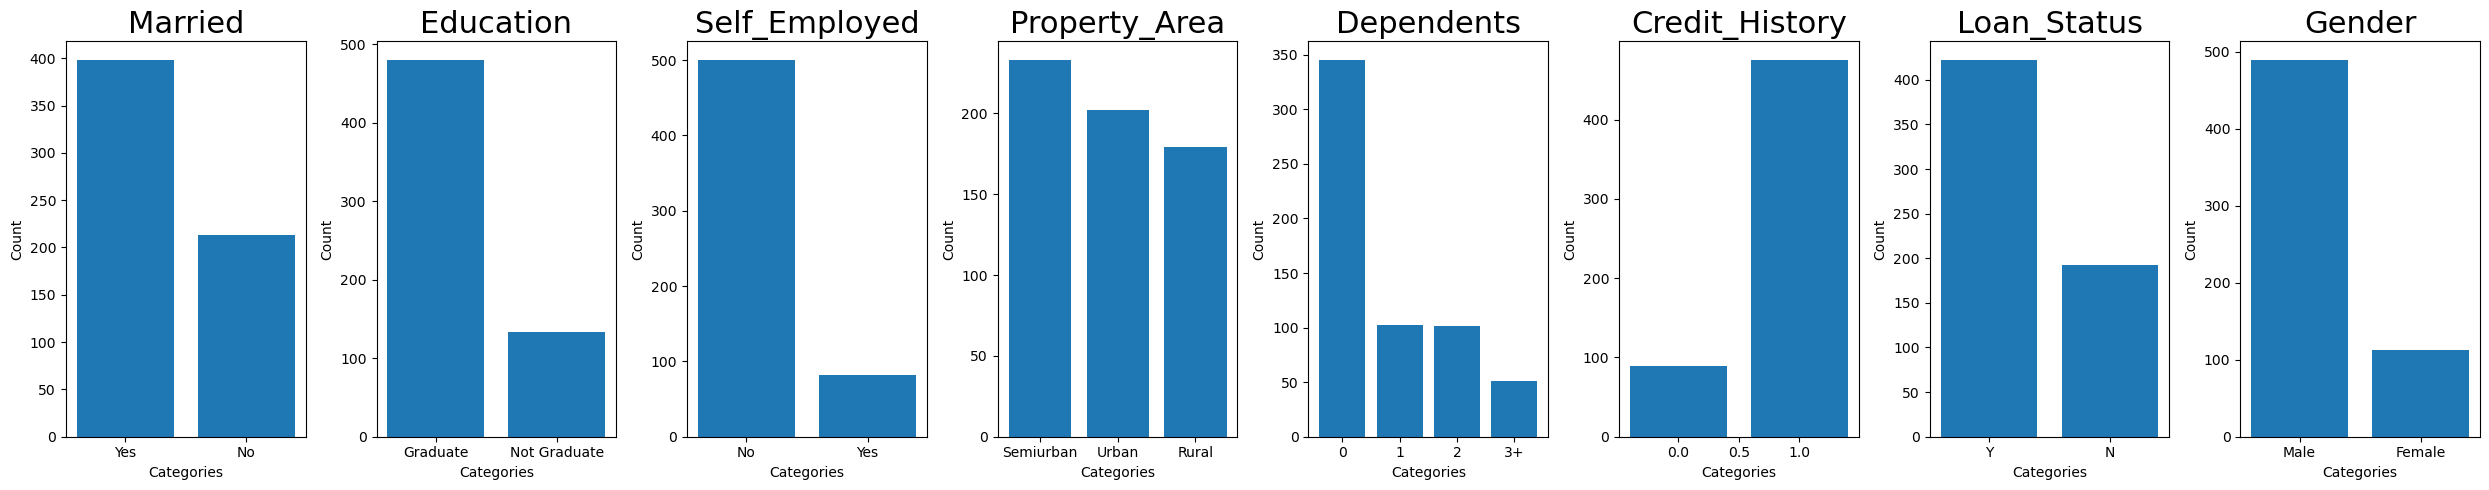

In [8]:
fig, axs = plt.subplots(1, len(df1.columns), figsize=(25, 5))

# loop through each column and create a bar plot in a subplot
for i, col in enumerate(df1.columns):
    if col != 'Loan_ID':
        counts = df1[col].value_counts()
        axs[i-1].bar(counts.index, counts.values)
        axs[i-1].set_title(col,fontsize=22)
        axs[i-1].set_xlabel('Categories')
        axs[i-1].set_ylabel('Count')

# adjust spacing between subplots and show figure
fig.tight_layout()
plt.show()

### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



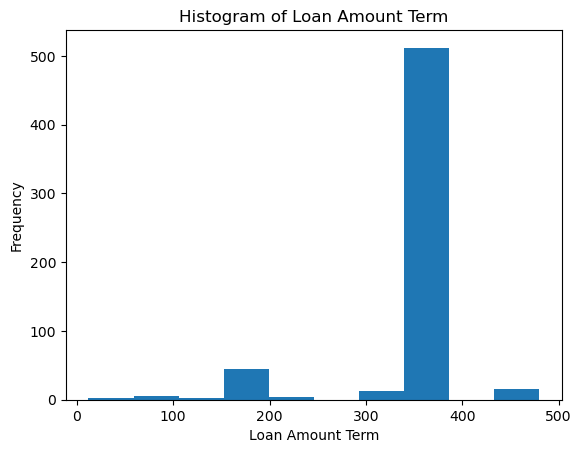

In [9]:
#Loan_Amount_Term Histogram

plt.hist(df['Loan_Amount_Term'], bins=10)
plt.xlabel('Loan Amount Term')
plt.ylabel('Frequency')
plt.title('Histogram of Loan Amount Term')
plt.show()

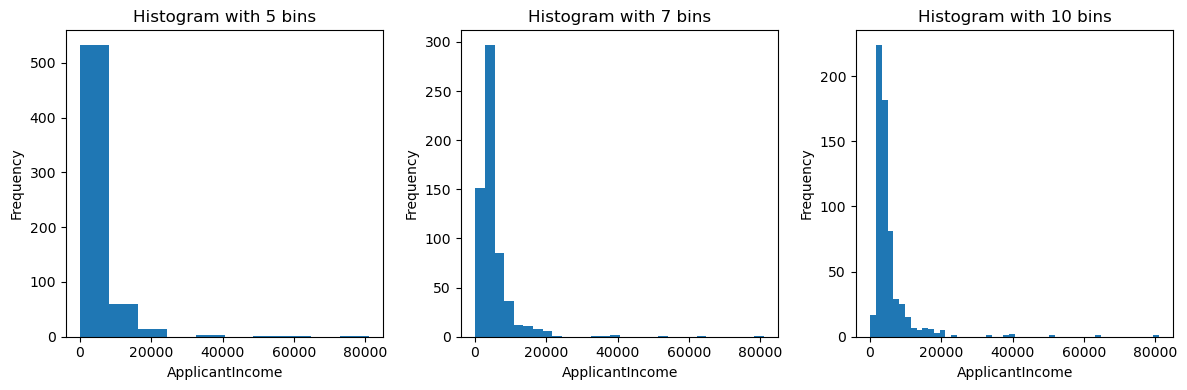

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(df['ApplicantIncome'], bins=10)
axs[0].set_title('Histogram with 5 bins')
axs[0].set_xlabel('ApplicantIncome')
axs[0].set_ylabel('Frequency')
axs[1].hist(df['ApplicantIncome'], bins=30)
axs[1].set_title('Histogram with 7 bins')
axs[1].set_xlabel('ApplicantIncome')
axs[1].set_ylabel('Frequency')
axs[2].hist(df['ApplicantIncome'], bins=50)
axs[2].set_title('Histogram with 10 bins')
axs[2].set_xlabel('ApplicantIncome')
axs[2].set_ylabel('Frequency')
fig.tight_layout()
plt.show()

Look at box plots to understand the distributions. 

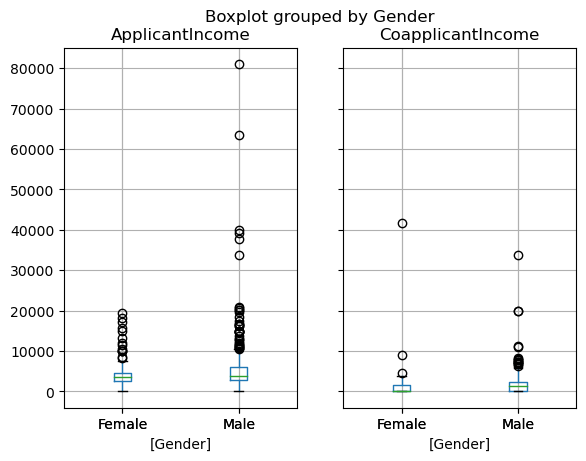

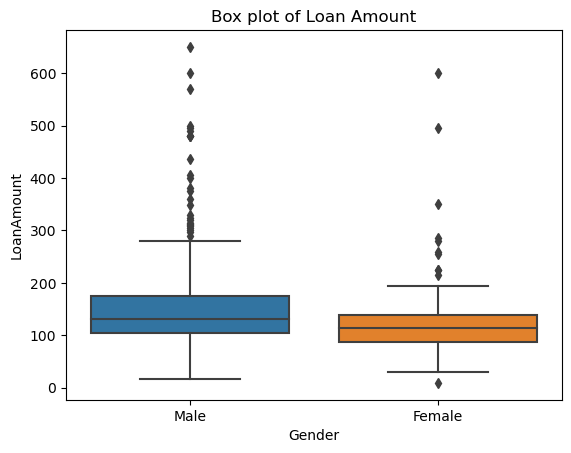

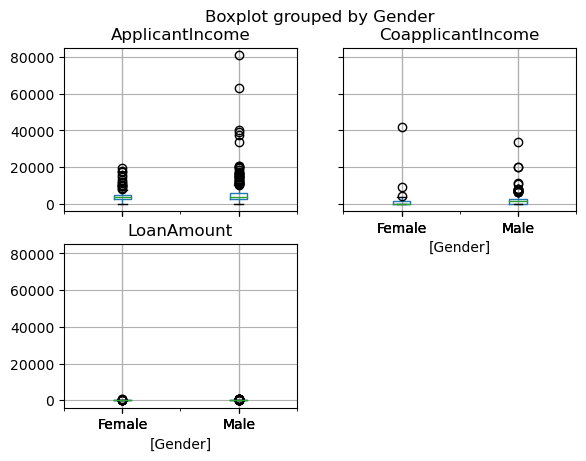

In [11]:
# Plot box plot of Applicant and Coapplicant Income
df.boxplot(column= ['ApplicantIncome', 'CoapplicantIncome'], by = ['Gender'])
plt.show()

# Plot box plot of LoanAmount
sns.boxplot(x = df['Gender'], y = df['LoanAmount'])
plt.title('Box plot of Loan Amount')
plt.show()

# Plot box plot of Applicant Income, Coapplicant Income and Loan Amount
df.boxplot(column = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], by = ['Gender'])
plt.show()

Look at the distribution of income segregated  by `Education`

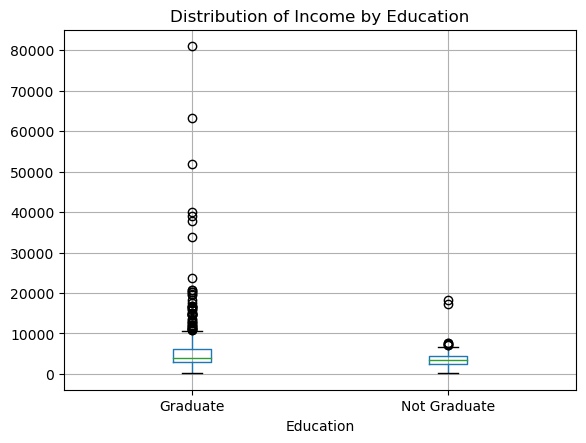

In [12]:
df.boxplot(column='ApplicantIncome', by='Education')
plt.title('Distribution of Income by Education')
plt.suptitle('')  # suppress the default title created by pandas
plt.show()

Look at the histogram and boxplot of LoanAmount

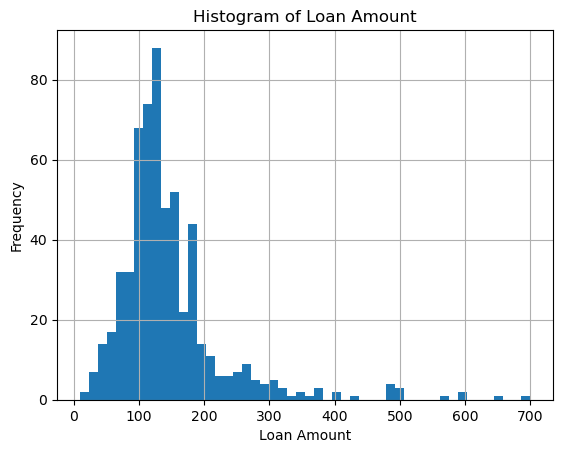

In [13]:
# Histogram of LoanAmount
df['LoanAmount'].hist(bins=50)
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Loan Amount')
plt.show()

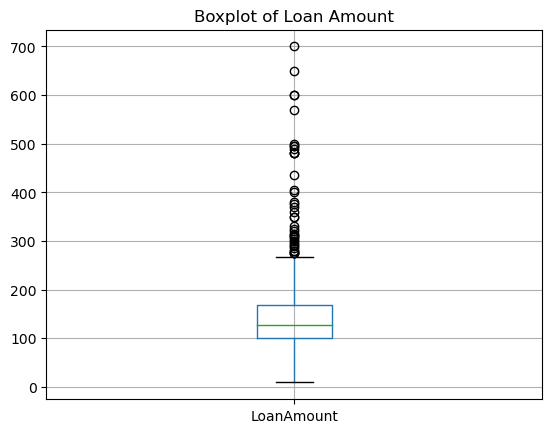

In [14]:
# Boxplot of LoanAmount

df.boxplot(column='LoanAmount')
plt.title('Boxplot of Loan Amount')
plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis


Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

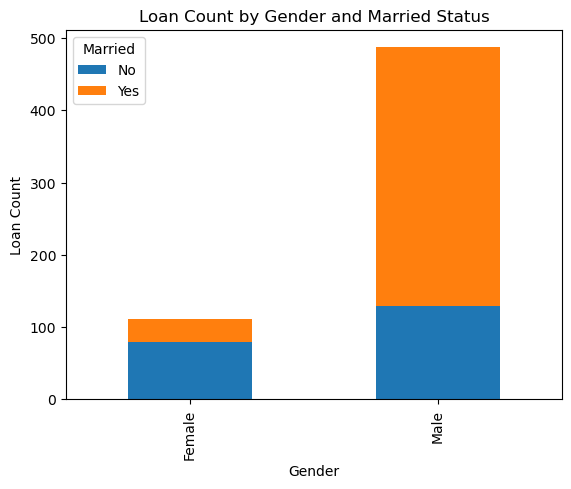

In [15]:
# create pivot table to count number of loans by gender and married status
loan_count = df.pivot_table(index='Gender', columns='Married', values='Loan_Status', aggfunc='count')

# create stacked bar chart to visualize loan count by gender and married status
ax = loan_count.plot(kind='bar', stacked=True)
ax.set_title('Loan Count by Gender and Married Status')
ax.set_xlabel('Gender')
ax.set_ylabel('Loan Count')
plt.show()



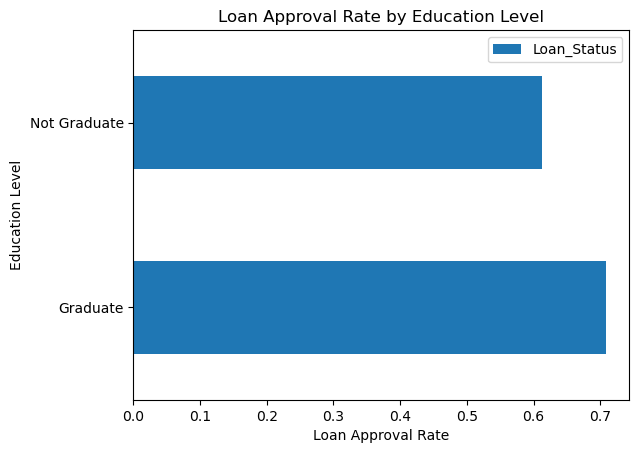

In [16]:
# create pivot table to calculate loan approval rate by education level
approval_rate = df.pivot_table(index='Education', values='Loan_Status', aggfunc=lambda x: sum(x=='Y')/len(x))

# create horizontal bar chart to visualize loan approval rate by education level
ax = approval_rate.plot(kind='barh')
ax.set_title('Loan Approval Rate by Education Level')
ax.set_xlabel('Loan Approval Rate')
ax.set_ylabel('Education Level')
plt.show()

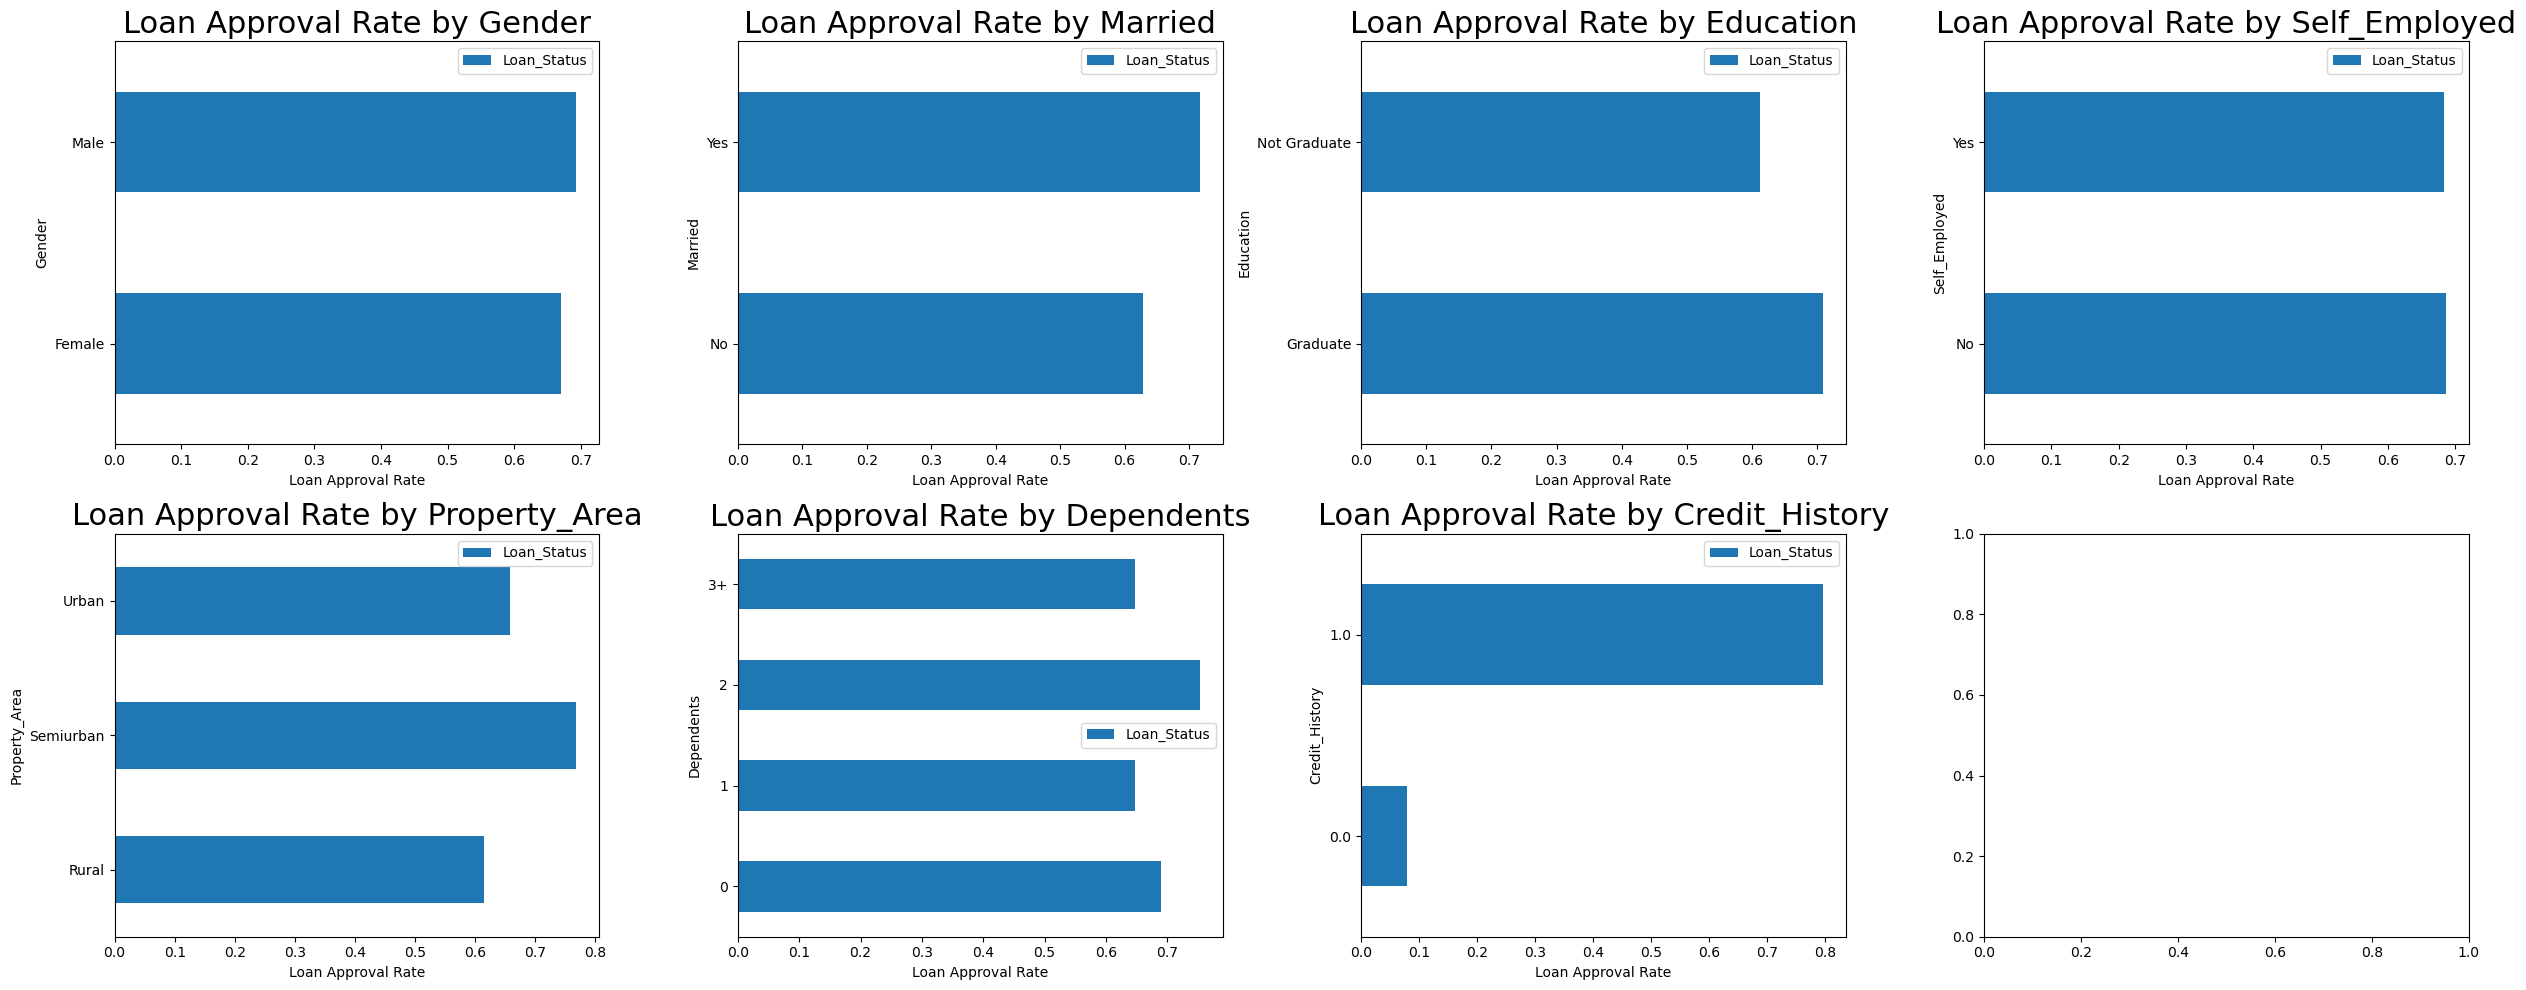

In [17]:
fig, axs = plt.subplots(2, len(df1.columns)//2, figsize=(25, 10))

for i, ax in zip(df1.columns, axs.flatten()):
    if i != 'Loan_Status':
        # create pivot table to calculate loan approval rate by education level
        approval_rate = df.pivot_table(index=i, values='Loan_Status', aggfunc=lambda x: sum(x=='Y')/len(x))

        # create horizontal bar chart to visualize loan approval rate by education level
        approval_rate.plot(kind='barh', ax=ax)
        ax.set_title(f'Loan Approval Rate by {i}',fontsize=22)
        ax.set_xlabel('Loan Approval Rate')
        ax.set_ylabel(i)

fig.tight_layout()
plt.show()

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [18]:
df.head(3)

Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001002   Male      No          0  Graduate            No   
1  LP001003   Male     Yes          1  Graduate            No   
2  LP001005   Male     Yes          0  Graduate           Yes   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y

In [19]:
df.isnull().sum()[df.isnull().sum()>0]

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [20]:
#Gender--------Mode------
df['Gender'] = df['Gender'].fillna('Male')
#Married
df['Married'] = df['Married'].fillna('Yes')

In [21]:
#Dependents--------Mode------
mode_val_Dependents = df['Dependents'].mode()[0]  # get the mode value
df['Dependents'].fillna(mode_val_Dependents, inplace=True)  # replace null values with mode value

In [22]:
#Self_Employed--------Mode------
mode_val_Self_Employed = df['Self_Employed'].mode()[0]  # get the mode value
df['Self_Employed'].fillna(mode_val_Self_Employed, inplace=True)  # replace null values with mode value

In [23]:
#LoanAmount ----Mean Value-----
mean_loan_amount = df['LoanAmount'].mean()
df['LoanAmount'].fillna(mean_loan_amount, inplace=True)

In [24]:
#Loan_Amount_Term --------Mode------
mode_value_Term = df['Loan_Amount_Term'].mode()[0]
df['Loan_Amount_Term'].fillna(mode_value_Term, inplace=True)

In [25]:
#Credit_History
mode_value_Credit_History = df['Credit_History'].mode()[0]
df['Credit_History'].fillna(mode_value_Credit_History, inplace=True)

In [26]:
# replace gender values with 1 and 0 
df['Gender'] = df['Gender'].replace({"Male": 1, "Female": 0})
# replace married values with 1 and 0
df['Married'] = df['Married'].replace({"Yes": 1, "No": 0})
# replace self employed values with 1 and 0
df['Self_Employed'] = df['Self_Employed'].replace({"Yes": 1, "No": 0})
# change loan amount term into years
df['Loan_Amount_Term'] = df['Loan_Amount_Term']/12
# replace loan status values with 1 and 0
df['Loan_Status'] = df['Loan_Status'].replace({"Y": 1, "N": 0})
# check null values again
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

In [27]:
df['log_LoanAmount'] = df['LoanAmount'].apply(lambda x: np.log(np.clip(x, 1, None)))

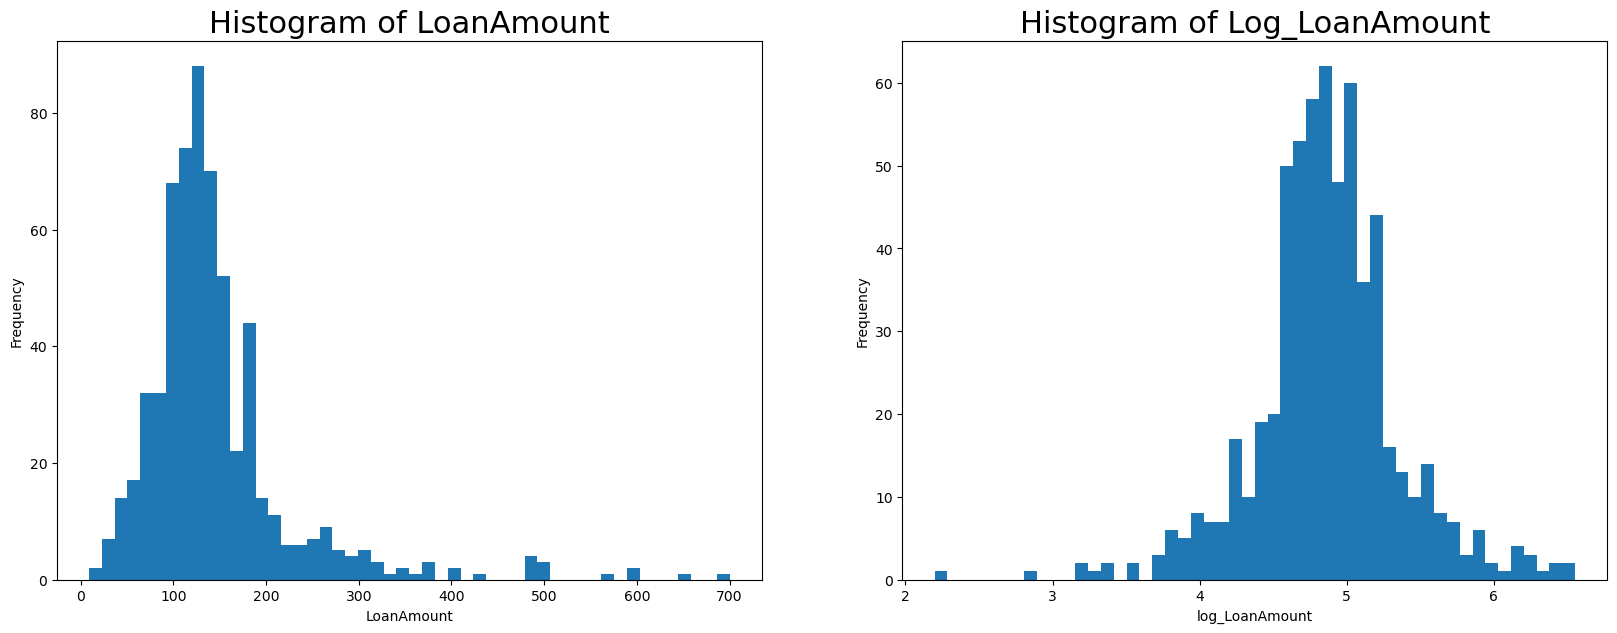

In [28]:
# Plot the histogram before and after the transformation
fig, axs = plt.subplots(1, 2, figsize=(20,7))

axs[0].hist(df['LoanAmount'], bins=50)
axs[0].set_xlabel('LoanAmount')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of LoanAmount',fontsize=22)

#histogram after transformation

axs[1].hist(df['log_LoanAmount'], bins=50)
axs[1].set_xlabel('log_LoanAmount')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Log_LoanAmount',fontsize=22)
plt.show()


Combine both incomes as total income and take a log transformation of the same.

In [29]:
df['total_income']=df['CoapplicantIncome']+df['ApplicantIncome']

In [30]:
df['log_total_income'] = df['total_income'].apply(lambda x: np.log(np.clip(x, 1, None)))

## 4. Building a Predictive Model

In [31]:
df.head()

Loan_ID  Gender  Married Dependents     Education  Self_Employed  \
0  LP001002       1        0          0      Graduate              0   
1  LP001003       1        1          1      Graduate              0   
2  LP001005       1        1          0      Graduate              1   
3  LP001006       1        1          0  Not Graduate              0   
4  LP001008       1        0          0      Graduate              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0  146.412162              30.0   
1             4583             1508.0  128.000000              30.0   
2             3000                0.0   66.000000              30.0   
3             2583             2358.0  120.000000              30.0   
4             6000                0.0  141.000000              30.0   

   Credit_History Property_Area  Loan_Status  log_LoanAmount  total_income  \
0             1.0         Urban            1        4.986426        5849.0   
1             1.0         Rural            0        4.852030        6091.0   
2             1.0         Urban            1        4.189655        3000.0   
3             1.0         Urban            1        4.787492        4941.0   
4             1.0         Urban            1        4.948760        6000.0   

   log_total_income  
0          8.674026  
1          8.714568  
2          8.006368  
3          8.505323  
4          8.699515

### Preparing df for modeling

In [32]:
# Drop columns that are not needed for modeling
df_model = df.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','total_income'], axis = 1)

# turn dependent variable into category
df_model['Dependents'] = df_model['Dependents'].astype('category')

# get dummies for categorical variables
df_model = pd.get_dummies(df_model, columns = ['Education','Property_Area','Dependents'])
df_model.head()

Gender  Married  Self_Employed  Loan_Amount_Term  Credit_History  \
0       1        0              0              30.0             1.0   
1       1        1              0              30.0             1.0   
2       1        1              1              30.0             1.0   
3       1        1              0              30.0             1.0   
4       1        0              0              30.0             1.0   

   Loan_Status  log_LoanAmount  log_total_income  Education_Graduate  \
0            1        4.986426          8.674026                   1   
1            0        4.852030          8.714568                   1   
2            1        4.189655          8.006368                   1   
3            1        4.787492          8.505323                   0   
4            1        4.948760          8.699515                   1   

   Education_Not Graduate  Property_Area_Rural  Property_Area_Semiurban  \
0                       0                    0                        0   
1                       0                    1                        0   
2                       0                    0                        0   
3                       1                    0                        0   
4                       0                    0                        0   

   Property_Area_Urban  Dependents_0  Dependents_1  Dependents_2  \
0                    1             1             0             0   
1                    0             0             1             0   
2                    1             1             0             0   
3                    1             1             0             0   
4                    1             1             0             0   

   Dependents_3+  
0              0  
1              0  
2              0  
3              0  
4              0

In [33]:
#Scaling
from sklearn.preprocessing import MinMaxScaler


df_scaled = df_model.copy()
cols_to_scale = ['Loan_Amount_Term', 'log_LoanAmount', 'log_total_income']
X = df_scaled[cols_to_scale]

# Create scaler and fit to X
scaler = MinMaxScaler()
scaler.fit(X)

# Transform X using scaler
X_scaled = scaler.transform(X)

# Replace original columns with scaled data
df_scaled[cols_to_scale] = X_scaled

df_scaled.head()

Gender  Married  Self_Employed  Loan_Amount_Term  Credit_History  \
0       1        0              0           0.74359             1.0   
1       1        1              0           0.74359             1.0   
2       1        1              1           0.74359             1.0   
3       1        1              0           0.74359             1.0   
4       1        0              0           0.74359             1.0   

   Loan_Status  log_LoanAmount  log_total_income  Education_Graduate  \
0            1        0.640628          0.347590                   1   
1            0        0.609760          0.357654                   1   
2            1        0.457624          0.181853                   1   
3            1        0.594936          0.305712                   0   
4            1        0.631977          0.353918                   1   

   Education_Not Graduate  Property_Area_Rural  Property_Area_Semiurban  \
0                       0                    0                        0   
1                       0                    1                        0   
2                       0                    0                        0   
3                       1                    0                        0   
4                       0                    0                        0   

   Property_Area_Urban  Dependents_0  Dependents_1  Dependents_2  \
0                    1             1             0             0   
1                    0             0             1             0   
2                    1             1             0             0   
3                    1             1             0             0   
4                    1             1             0             0   

   Dependents_3+  
0              0  
1              0  
2              0  
3              0  
4              0

In [34]:
# Find the first 100 principle components of the dataset
pca = PCA(n_components=17)
pca.fit(df_scaled)

# Transform the data to its low-dimensional representation
reduced_col = pca.transform(df_scaled)

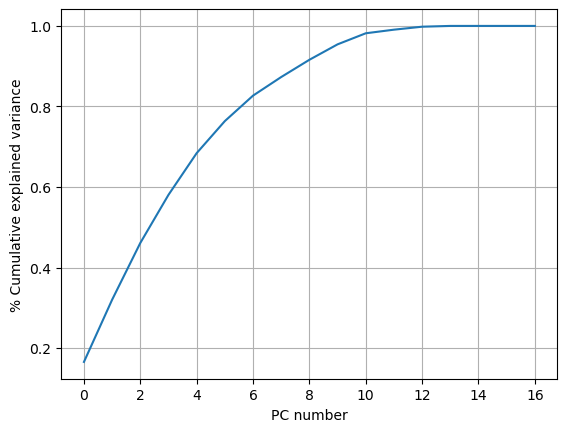

In [35]:
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')
plt.grid(True)

As the loan prediction can be represented by a binary classification, we are going to use the Logistic Regression Model as our baseline model first. 

### logistic regression model 

In [36]:
# Separating the dataframe between the X (independent) and y (dependent) variables
X = df_scaled.drop('Loan_Status', axis=1)
y = df_scaled['Loan_Status']

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [37]:
# Splitting the set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

In [38]:
# Applying the .fit() and .predict() methods to our baseline_model_1
baseline_model_1 = LogisticRegression(max_iter=1000, random_state=100) # Creating an instance of the LogisticRegression model
baseline_model_1.fit(X_train, y_train) # Fitting the model to the training data
y_pred_1 = baseline_model_1.predict(X_test) # Predicting the target variable for the test data

# Evaluating the model performance
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1)
recall_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)
roc_auc_1 = roc_auc_score(y_test, y_pred_1)
confusion_mat_1 = confusion_matrix(y_test, y_pred_1)

# Printing the evaluation metrics
print("Accuracy: ", accuracy_1)
print("Precision: ", precision_1)
print("Recall: ", recall_1)
print("F1-score: ", f1_1)
print("ROC-AUC score: ", roc_auc_1)
print("Confusion Matrix:\n", confusion_mat_1)

Accuracy:  0.7402597402597403
Precision:  0.7109375
Recall:  0.9680851063829787
F1-score:  0.8198198198198199
ROC-AUC score:  0.675709219858156
Confusion Matrix:
 [[23 37]
 [ 3 91]]


The logistic regression model achieved an accuracy of 0.74 on the test set, which means that 74% of the predictions made by the model were correct. The model also achieved a precision of 0.71, which means that out of all the positive predictions made by the model, 71% were correct. The recall score of 0.97 indicates that the model was able to correctly identify 97% of the actual positive cases in the test set. The F1-score of 0.82 is the harmonic mean of precision and recall, and provides an overall measure of the model's performance. The ROC-AUC score of 0.68 indicates that the model's ability to distinguish between positive and negative cases is only slightly better than random chance. The confusion matrix shows that the model correctly predicted 23 negative cases and 91 positive cases, but incorrectly predicted 37 negative cases and 3 positive cases.

### RandomForest Model

In [39]:
# Applying the .fit() and .predict() methods to our baseline_model_2
baseline_model_2 = RandomForestClassifier(n_estimators=1000, random_state=100) # Creating an instance of the Random Forest model
baseline_model_2.fit(X_train, y_train) # Fitting the model to the training data
y_pred_2 = baseline_model_2.predict(X_test) # Predicting the target variable for the test data

# Evaluating the model performance
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2)
recall_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)
roc_auc_2 = roc_auc_score(y_test, y_pred_2)
confusion_mat_2 = confusion_matrix(y_test, y_pred_2)

# Printing the evaluation metrics
print("Accuracy: ", accuracy_2)
print("Precision: ", precision_2)
print("Recall: ", recall_2)
print("F1-score: ", f1_2)
print("ROC-AUC score: ", roc_auc_2)
print("Confusion Matrix:\n", confusion_mat_2)

Accuracy:  0.7467532467532467
Precision:  0.7235772357723578
Recall:  0.9468085106382979
F1-score:  0.8202764976958526
ROC-AUC score:  0.6900709219858157
Confusion Matrix:
 [[26 34]
 [ 5 89]]


### DecisionTreeClassifier

In [40]:
from sklearn.tree import DecisionTreeClassifier


dtcModel = DecisionTreeClassifier()
dtcModel.fit(X_train,y_train)
y_pred_dtcModel=dtcModel.predict(X_test)
y_pred_dtcModel

# Printing the evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred_dtcModel))
print("Precision: ", precision_score(y_test, y_pred_dtcModel))
print("Recall: ", recall_score(y_test, y_pred_dtcModel))
print("F1-score: ", f1_score(y_test, y_pred_dtcModel))
print("ROC-AUC score: ", roc_auc_score(y_test, y_pred_dtcModel))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtcModel))

Accuracy:  0.6363636363636364
Precision:  0.69
Recall:  0.7340425531914894
F1-score:  0.711340206185567
ROC-AUC score:  0.6086879432624114
Confusion Matrix:
 [[29 31]
 [25 69]]


### KNClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knnModel = KNeighborsClassifier(n_neighbors=3)

knnModel.fit(X_train, y_train)
y_pred_knnModel=knnModel.predict(X_test)
y_pred_knnModel

# Printing the evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred_knnModel))
print("Precision: ", precision_score(y_test, y_pred_knnModel))
print("Recall: ", recall_score(y_test, y_pred_knnModel))
print("F1-score: ", f1_score(y_test, y_pred_knnModel))
print("ROC-AUC score: ", roc_auc_score(y_test, y_pred_knnModel))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knnModel))

Accuracy:  0.6818181818181818
Precision:  0.6717557251908397
Recall:  0.9361702127659575
F1-score:  0.7822222222222222
ROC-AUC score:  0.6097517730496453
Confusion Matrix:
 [[17 43]
 [ 6 88]]


## Grid search to improve model

### Logistic Regression (Grid Search)

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer


In [43]:
df = pd.read_csv('../data/data.csv') 

In [44]:
# turn dependent variable into category
df['Dependents'] = df['Dependents'].astype('category')
# New Column
df['total_income']=df['CoapplicantIncome']+df['ApplicantIncome']
# Dropping unnecessary columns
df.drop(columns=['CoapplicantIncome','ApplicantIncome','Loan_ID'],inplace=True)
# change loan amount term into years
df['Loan_Amount_Term'] = df['Loan_Amount_Term']/12
# replace loan status values with 1 and 0
df['Loan_Status'] = df['Loan_Status'].replace({"Y": 1, "N": 0})

In [53]:
X=df.drop(columns='Loan_Status')
y=df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

# Define the transformation we want as a function
def log_transform(X):
    X_log = np.log(X)
    return X_log

log_transform_object = FunctionTransformer(log_transform)

# Define the transformation we want as a function
numeric_transform = Pipeline([('impute_mean', SimpleImputer(strategy='mean')),
                              ('log',log_transform_object),
                              ('scaling', MinMaxScaler())])
categorical_transform = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

# (name, transformer, list of column names)
preprocessing_tips = ColumnTransformer([('numeric', numeric_transform, ['LoanAmount', 'total_income']), 
                                        ('categorical', categorical_transform, 
                                         ['Education','Property_Area','Dependents','Gender','Married','Self_Employed'])])



#classifier=RandomForestClassifier(n_estimators=1000, random_state=100)
classifier=LogisticRegression()


pipeline = Pipeline(steps=[('preprocessing', preprocessing_tips),                           
                           ('classifier', classifier)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {acc}')

Test set accuracy: 0.577922077922078


In [52]:
# Display HTML representation in a jupyter context
from sklearn import set_config
set_config(display='diagram')

pipeline
# pipeline_tips

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x000001F40A7F0040>)),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  ['LoanAmount',
                                                   'total_income']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Education', 'Property_Area',
                                                   'Dependents', 'Gender',
                                                   'Married',
                                                   'Self_Employed'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=1000, random_state=100))])

In [46]:
# X = df[['Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'LoanAmount',
#        'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'total_income']]
# y = df.Loan_Status.map({'N':0,'Y':1})
# x_train,x_test,y_train,y_test = train_test_split(X,y)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print_scores(y_test,y_pred)

NameError: name 'print_scores' is not defined

In [ ]:
df_scaled

In [ ]:
Pipeline(steps=[('preprocess', preprocess),
                ('model',model)])

score = pipeline.score(X_test, y_test)

# Make predictions on new data
new_data = load_new_data()
predictions = pipeline.predict(new_data)

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python